In [1]:
import os
import torch
import torchaudio
import pandas as pd
import numpy as np
import random
from torch.utils.data import DataLoader
from dataset import AudioDataset
from model import ConvNet
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, average_precision_score, precision_recall_curve, f1_score
from IPython.display import display, Audio
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Create test dataset
data = AudioDataset(
    path=os.path.join("audiotest"),
    sample_rate=22050,
    n_mels=128,
    n_fft=1024,
    win_length=512,
    hop_length=512
    )
dataloader = DataLoader(data, batch_size=32)

In [4]:
# Get filenames and corresponding labels
filenames = data.file_paths
labels = data.labels
print(f"Number of audio files: {len(filenames)}\n")
print(f"Example filenames:\n{filenames[:3]}\n")
print(f"Example labels:\n{labels[:3]}")

Number of audio files: 7353

Example filenames:
['test/music/radio-3fm_20191103.1855_233.wav', 'test/music/radio-3fm_20191103.1956_350.wav', 'test/music/veronica_20191103.1956_50.wav']

Example labels:
[1, 1, 1]


In [5]:
# Load input data
tensors = [data[i][0] for i in range(len(filenames))]
inputs = [x.numpy() for x in tensors]

In [6]:
df = pd.DataFrame({"filepath": filenames, "label": labels})
df["label_text"] = np.where(df.label == 0, "Ads/other", "Music")
df.head()

,filepath,label,label_text
0,test/music/radio-3fm_20191103.1855_233.wav,1,Music
1,test/music/radio-3fm_20191103.1956_350.wav,1,Music
2,test/music/veronica_20191103.1956_50.wav,1,Music
3,test/music/radio-3fm_20191103.1855_189.wav,1,Music
4,test/music/q-music-non-stop_20191103.1855_643.wav,1,Music


In [7]:
# Load model
model = ConvNet()
model.load_state_dict(torch.load("model_15_0.1388.pth"))
model.to(device)
model.eval()

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=

In [8]:
# Make predictions
predictions = []
with torch.no_grad():
    for i, batch in enumerate(dataloader):
        x, y = batch
        x, y = x.to(device), y.to(device)
        pred = model(x).squeeze()
        predictions.append(pred)

predictions = torch.cat(predictions).cpu().numpy()

In [9]:
# Make predictions (change to use GPU)
df["pred_prob"] = predictions
df["prediction"] = np.where(df["pred_prob"] > 0.5, 1, 0)
df["prediction_text"] = df.prediction.replace({0: "Ads/other", 1: "Music"})

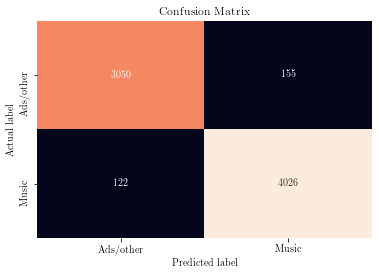

In [10]:
# Plot confusion matrix
matrix = pd.DataFrame(confusion_matrix(df.label, df.prediction, labels=[0, 1]), 
                      index=["Ads/other", "Music"], columns=["Ads/other", "Music"])
fig = sns.heatmap(matrix, annot=True, fmt=".0f", cbar=False)
fig.set_title("Confusion Matrix")
fig.set_xlabel("Predicted label")
fig.set_ylabel("Actual label");

In [11]:
# Calculate test accuracy
acc = (df.prediction == df.label).sum() / df.shape[0]
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9623


In [12]:
# Calculate precision and recall using current threshold
print(f"Precision: {precision_score(df.label, df.prediction):.4f}")
print(f"Recall: {recall_score(df.label, df.prediction):.4f}")

Precision: 0.9629
Recall: 0.9706


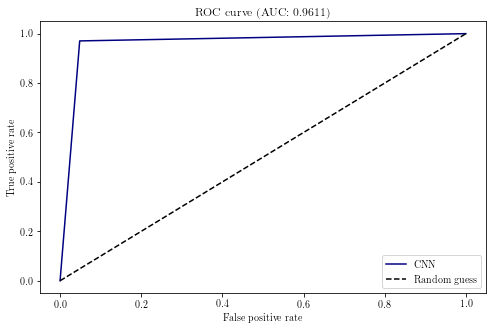

In [13]:
# AUC-ROC curve
fpr, tpr, _ = roc_curve(df.label, df.prediction)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, "navy")
plt.plot([0, 1], [0, 1], color="black", linestyle='--')
plt.title(f"ROC curve (AUC: {auc(fpr, tpr):.4f})")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["CNN", "Random guess"]);

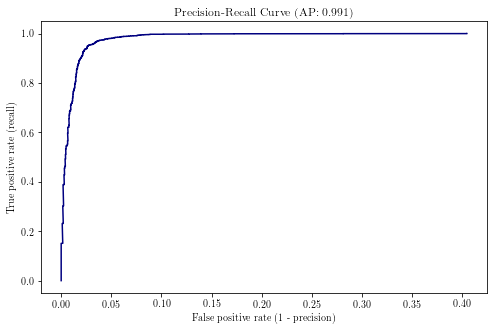

In [14]:
# Precision-recall curve
avg_precision = average_precision_score(df.label, df.pred_prob)
precision, recall, thresholds = precision_recall_curve(df.label, df.pred_prob)
plt.figure(figsize=(8, 5))
plt.plot(1 - precision, recall, "navy")
plt.title(f"Precision-Recall Curve (AP: {avg_precision:.3f})")
plt.xlabel("False positive rate (1 - precision)")
plt.ylabel("True positive rate (recall)");

In [15]:
# Calculate F1-score
print(f"F1-score: {round(f1_score(df.label, df.prediction), 4)}")

F1-score: 0.9667


In [16]:
df.columns

Index(['filepath', 'label', 'label_text', 'pred_prob', 'prediction',
       'prediction_text'],
      dtype='object')

In [17]:
def show_snippet_info(index):
    print(f"Filename: {df.filepath[i]}")
    print(f"Actual label: {df.label_text[i]} ({df.label[i]})")
    print(f"Predicted label: {df.prediction_text[i]} ({df.pred_prob[i]:.4f})")

    print("Audio:")
    display(Audio(df.filepath[i], embed=True, rate=22050))

    print("Mel spectrogram:")
    plt.figure()
    plt.imshow(inputs[i].squeeze(), cmap="magma")
    plt.show()

Filename: test/music/q-music-non-stop_20190530.1200_6318.wav
Actual label: Music (1)
Predicted label: Music (0.9997)
Audio:


Mel spectrogram:


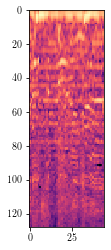

Filename: test/music/q-music-non-stop_20191103.1855_669.wav
Actual label: Music (1)
Predicted label: Music (0.5508)
Audio:


Mel spectrogram:


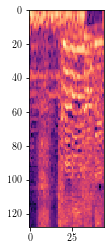

Filename: test/ads_other/radio-1_20191103.1855_817.wav
Actual label: Ads/other (0)
Predicted label: Ads/other (0.0000)
Audio:


Mel spectrogram:


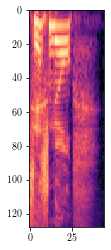

Filename: test/ads_other/radio-1_20191103.1855_1192.wav
Actual label: Ads/other (0)
Predicted label: Ads/other (0.0011)
Audio:


Mel spectrogram:


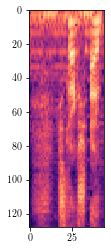

Filename: test/ads_other/q-music_20190530.1200_693.wav
Actual label: Ads/other (0)
Predicted label: Ads/other (0.0015)
Audio:


Mel spectrogram:


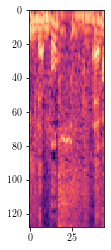

In [18]:
# Examples of correct predictions
indices_correct = df.index[df.label == df.prediction].tolist()
for i in random.sample(indices_correct, 5):
    show_snippet_info(i)

Filename: test/music/sky-radio-non-stop_20191109.1355_870.wav
Actual label: Music (1)
Predicted label: Ads/other (0.0233)
Audio:


Mel spectrogram:


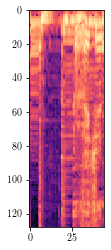

Filename: test/music/npo-2_20190612.1200_5713.wav
Actual label: Music (1)
Predicted label: Ads/other (0.3913)
Audio:


Mel spectrogram:


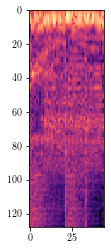

Filename: test/ads_other/radio-3fm_20191103.1855_766.wav
Actual label: Ads/other (0)
Predicted label: Music (0.9279)
Audio:


Mel spectrogram:


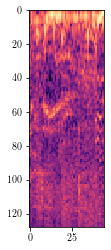

Filename: test/music/npo-2_20190612.1200_3292.wav
Actual label: Music (1)
Predicted label: Ads/other (0.0859)
Audio:


Mel spectrogram:


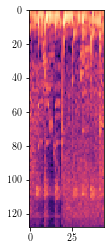

Filename: test/ads_other/q-music-non-stop_20191103.1855_50.wav
Actual label: Ads/other (0)
Predicted label: Music (0.8911)
Audio:


Mel spectrogram:


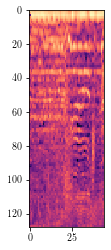

In [19]:
# Examples of incorrect predictions
indices_incorrect = df.index[df.label != df.prediction].tolist()
for i in random.sample(indices_incorrect, 5):
    show_snippet_info(i)